In [1]:
# 필요한 패키지 불러오기

from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

# 학습시킬 데이터 불러오기

caltech_dir = "./data/train"
categories = ["male", "female"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

# 데이터 전처리

for idx, cat in enumerate(categories):
    
    # one-hot 인코딩
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 50 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)

# 학습 데이터 테스트 데이터를 나눈뒤 np배열형식 외부파일로 저장
X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data.npy", xy)

print("ok", len(y))

male  파일 길이 :  985
male  :  ./data/train/male/male_ (295).jpg
male  :  ./data/train/male/male_ (426).jpg
male  :  ./data/train/male/male_ (301).jpg
male  :  ./data/train/male/male_ (741).jpg
male  :  ./data/train/male/male_ (132).jpg
male  :  ./data/train/male/male_ (188).jpg
male  :  ./data/train/male/male_ (11).jpg
male  :  ./data/train/male/male_ (1010).jpg
male  :  ./data/train/male/male_ (549).jpg
male  :  ./data/train/male/male_ (94).jpg
male  :  ./data/train/male/male_ (310).jpg
male  :  ./data/train/male/male_ (652).jpg
male  :  ./data/train/male/male_ (525).jpg
male  :  ./data/train/male/male_ (628).jpg
male  :  ./data/train/male/male_ (412).jpg
male  :  ./data/train/male/male_ (938).jpg
male  :  ./data/train/male/male_ (553).jpg
male  :  ./data/train/male/male_ (558).jpg
male  :  ./data/train/male/male_ (629).jpg
male  :  ./data/train/male/male_ (600).jpg
female  파일 길이 :  1050
female  :  ./data/train/female/female_ (1040).jpg
female  :  ./data/train/female/female_ (748).jpg
f

In [2]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data.npy')
print(X_train.shape)
print(X_train.shape[0])

Using TensorFlow backend.


(1526, 64, 64, 3)
1526


In [3]:
categories = ["male","female"]
nb_classes = len(categories)

# 일반화

X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [4]:
# 신경망 설계하기

with K.tf_ops.device('/device:GPU:0'): # 시스템의 첫번째 GPU를 지정함
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model_dir = './model' 
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
# 설계된 신경망 자세히 살펴보기

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
__________

In [6]:
# 설계한 모델 훈련시키기

history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 1526 samples, validate on 509 samples
Epoch 1/50
1526/1526 [==============================] - 9s 6ms/step - loss: 0.8456 - acc: 0.6016 - val_loss: 0.6156 - val_acc: 0.6994

Epoch 00001: val_loss improved from inf to 0.61558, saving model to ./model/multi_img_classification.model
Epoch 2/50
1526/1526 [==============================] - 8s 5ms/step - loss: 0.5057 - acc: 0.7595 - val_loss: 0.4439 - val_acc: 0.8251

Epoch 00002: val_loss improved from 0.61558 to 0.44390, saving model to ./model/multi_img_classification.model
Epoch 3/50
1526/1526 [==============================] - 8s 5ms/step - loss: 0.3298 - acc: 0.8683 - val_loss: 0.2623 - val_acc: 0.9175

Epoch 00003: val_loss improved from 0.44390 to 0.26231, saving model to ./model/multi_img_classification.model
Epoch 4/50
1526/1526 [==============================] - 8s 5ms/step - loss: 0.2400 - acc: 0.8952 - val_loss: 0.2102 - val_acc: 0.9352

Epoch 00004: val_loss improved from 

In [7]:
# 훈련 정확도

print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

509/509 [==============================] - 0s 770us/step
정확도 : 0.9627


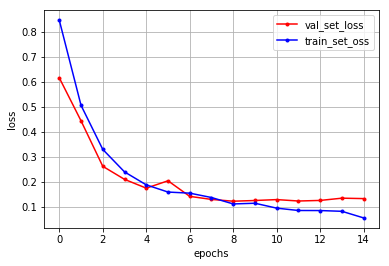

In [8]:
# 훈련 정확도 손실값 시각화

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [10]:
# 훈련된 모델로 예측값 검증하기

from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "./data/test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)

# numpy float 출력 옵션 변경 - 사용자가 포맷팅을 이용하여 원하는대로 배열 요소를 표시 가능
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

for i in prediction:
    pre_ans = i.argmax() 
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0:
        pre_ans_str = "남자"
    else:
        pre_ans_str = "여자"
    for k in range(len(i)):    
        if i[k] >= 0.8: 
            print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 "+pre_ans_str+"로 예측합니다.")
    cnt += 1

[1.000 0.000]
0
해당 ./data/test/female_ (348).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/male_ (900).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/female_ (674).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/male_ (373).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/female_ (421).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/male_ (201).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/male_ (178).jpg이미지는 남자로 예측합니다.
[0.000 1.000]
1
해당 ./data/test/male_ (37).jpg이미지는 여자로 예측합니다.
[0.000 1.000]
1
해당 ./data/test/female_ (82).jpg이미지는 여자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/male_ (282).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/female_ (627).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/female_ (164).jpg이미지는 남자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/male_ (248).jpg이미지는 남자로 예측합니다.
[0.000 1.000]
1
해당 ./data/test/female_ (189).jpg이미지는 여자로 예측합니다.
[0.000 1.000]
1
해당 ./data/test/male_ (264).jpg이미지는 여자로 예측합니다.
[1.000 0.000]
0
해당 ./data/test/female_ (559).jpg이미지는 남자로 예